<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B05%5D%20-%20Arboles%20de%20decision/Explicabilidad_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explicabilidad de modelos - Ejercicio 8: Explicabilidad_SHAP.ipynb

Este notebook es **We do**: lo hacemos juntos. Algunas celdas están resueltas para guiarte en las partes complejas, pero encontrarás comentarios `# TODO` dentro del código que debes completar durante la sesión. Ejecuta las celdas en orden, experimenta con los parámetros y anota tus decisiones.

Dataset Real

Wine Quality Dataset de UCI (1,599 vinos)
Si no se puede descargar, genera datos sintéticos automáticamente
Problema: Clasificar vinos de alta calidad vs. baja/media calidad

Flujo Completo

*   Carga y exploración de datos
*   Preparación del problema de clasificación binaria
*   División estratificada de datos
*   Entrenamiento de XGBoost con parámetros optimizados
*   Evaluación con métricas estándar
*   Entender POR QUÉ el modelo toma cada decisión usando SHAP
*   Explicaciones individuales detalladas
*   Análisis global de patrones

In [1]:
#Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Carga de datos y preparación

Cargar dataset Vinos

In [2]:

# Cargar dataset directamente desde UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

try:
    # Leer datos
    df = pd.read_csv(url, sep=';')
    print(f"✅ Dataset cargado exitosamente!")
    print(f"📏 Dimensiones: {df.shape[0]} filas, {df.shape[1]} columnas")
    print()

    # Mostrar primeras filas
    print("🔍 PRIMERAS 5 FILAS:")
    print(df.head())
    print()

    # Información básica
    print("📋 INFORMACIÓN DEL DATASET:")
    print(df.info())
    print()

    # Estadísticas básicas
    print("📊 ESTADÍSTICAS BÁSICAS:")
    print(df.describe())
    print()

except Exception as e:
    print(f"❌ Error cargando datos: {e}")
    print("💡 Usando datos sintéticos para el ejemplo...")

    # Crear datos sintéticos si falla la descarga
    np.random.seed(42)
    n_samples = 1000

    df = pd.DataFrame({
        'fixed acidity': np.random.normal(8.3, 1.7, n_samples),
        'volatile acidity': np.random.normal(0.5, 0.2, n_samples),
        'citric acid': np.random.normal(0.27, 0.2, n_samples),
        'residual sugar': np.random.normal(2.5, 1.4, n_samples),
        'chlorides': np.random.normal(0.09, 0.05, n_samples),
        'free sulfur dioxide': np.random.normal(16, 10, n_samples),
        'total sulfur dioxide': np.random.normal(46, 32, n_samples),
        'density': np.random.normal(0.997, 0.002, n_samples),
        'pH': np.random.normal(3.3, 0.15, n_samples),
        'sulphates': np.random.normal(0.66, 0.17, n_samples),
        'alcohol': np.random.normal(10.4, 1.1, n_samples),
        'quality': np.random.choice(range(3, 9), n_samples,
                                   p=[0.1, 0.15, 0.25, 0.3, 0.15, 0.05])
    })

✅ Dataset cargado exitosamente!
📏 Dimensiones: 1599 filas, 12 columnas

🔍 PRIMERAS 5 FILAS:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.5

In [3]:
# ============================================================================
# 🎯 PASO 2: PREPARAR EL PROBLEMA DE CLASIFICACIÓN
# ============================================================================

print("🎯 PREPARANDO PROBLEMA DE CLASIFICACIÓN:")
print("-" * 40)

# Convertir a problema binario: ¿Es un vino de alta calidad?
# Consideramos "alta calidad" si quality >= 7
df['alta_calidad'] = (df['quality'] >= 7).astype(int)

# Separar features (X) y target (y)
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
           'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
           'pH', 'sulphates', 'alcohol']

X = df[features].copy()
y = df['alta_calidad']

print(f"📊 Features utilizadas: {len(features)}")
print(f"🎯 Target: Vino de alta calidad (1) vs. baja/media calidad (0)")
print(f"📈 Distribución del target:")
print(f"   - Alta calidad (1): {y.sum()} vinos ({y.mean()*100:.1f}%)")
print(f"   - Baja/media calidad (0): {(y==0).sum()} vinos ({(1-y.mean())*100:.1f}%)")
print()

# Renombrar columnas para mejor legibilidad
column_mapping = {
    'fixed acidity': 'Acidez_Fija',
    'volatile acidity': 'Acidez_Volátil',
    'citric acid': 'Ácido_Cítrico',
    'residual sugar': 'Azúcar_Residual',
    'chlorides': 'Cloruros',
    'free sulfur dioxide': 'SO2_Libre',
    'total sulfur dioxide': 'SO2_Total',
    'density': 'Densidad',
    'pH': 'pH',
    'sulphates': 'Sulfatos',
    'alcohol': 'Alcohol'
}

X = X.rename(columns=column_mapping)
print("✅ Nombres de columnas limpiados para mejor interpretación")
print()

🎯 PREPARANDO PROBLEMA DE CLASIFICACIÓN:
----------------------------------------
📊 Features utilizadas: 11
🎯 Target: Vino de alta calidad (1) vs. baja/media calidad (0)
📈 Distribución del target:
   - Alta calidad (1): 217 vinos (13.6%)
   - Baja/media calidad (0): 1382 vinos (86.4%)

✅ Nombres de columnas limpiados para mejor interpretación



In [4]:
# ============================================================================
# 🔪 PASO 3: DIVIDIR DATOS
# ============================================================================

from sklearn.model_selection import train_test_split

print("🔪 DIVIDIENDO DATOS:")
print("-" * 20)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Entrenamiento: {X_train.shape[0]} muestras")
print(f"📊 Test: {X_test.shape[0]} muestras")
print(f"✅ División estratificada manteniendo proporciones")
print()

🔪 DIVIDIENDO DATOS:
--------------------
📊 Entrenamiento: 1279 muestras
📊 Test: 320 muestras
✅ División estratificada manteniendo proporciones



In [5]:
# ============================================================================
# 🚀 PASO 4: ENTRENAR MODELO XGBOOST
# ============================================================================

print("🚀 ENTRENANDO MODELO XGBOOST:")
print("-" * 30)

try:
    import xgboost as xgb
    print("✅ XGBoost encontrado")
except ImportError:
    print("❌ XGBoost no encontrado. Instalando...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'xgboost'])
    import xgboost as xgb

# Configurar modelo XGBoost
model = xgb.XGBClassifier(
    n_estimators=100,        # Número de árboles
    max_depth=4,             # Profundidad máxima
    learning_rate=0.1,       # Tasa de aprendizaje
    random_state=42,         # Reproducibilidad
    eval_metric='logloss'    # Métrica de evaluación
)

# Entrenar modelo
print("🎯 Entrenando modelo...")
model.fit(X_train, y_train)
print("✅ Modelo entrenado exitosamente!")
print()

🚀 ENTRENANDO MODELO XGBOOST:
------------------------------
✅ XGBoost encontrado
🎯 Entrenando modelo...
✅ Modelo entrenado exitosamente!



In [6]:
# ============================================================================
# 📊 PASO 5: EVALUAR MODELO
# ============================================================================

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("📊 EVALUACIÓN DEL MODELO:")
print("-" * 25)

# Predicciones
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Métricas básicas
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print()

# Reporte de clasificación
print("📋 REPORTE DETALLADO:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("🎭 MATRIZ DE CONFUSIÓN:")
cm = confusion_matrix(y_test, y_pred)
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")
print()


📊 EVALUACIÓN DEL MODELO:
-------------------------
🎯 Accuracy: 0.938 (93.8%)

📋 REPORTE DETALLADO:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       277
           1       0.90      0.60      0.72        43

    accuracy                           0.94       320
   macro avg       0.92      0.80      0.84       320
weighted avg       0.94      0.94      0.93       320

🎭 MATRIZ DE CONFUSIÓN:
TN: 274, FP: 3
FN: 17, TP: 26



In [7]:
# ============================================================================
# 🎨 PASO 6: IMPORTANCIA DE FEATURES (TRADICIONAL)
# ============================================================================

print("🎨 IMPORTANCIA TRADICIONAL DE FEATURES:")
print("-" * 40)

# Importancia built-in de XGBoost
feature_importance = model.feature_importances_
feature_names = X.columns

# Crear DataFrame para mejor visualización
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("🔝 TOP 5 FEATURES MÁS IMPORTANTES:")
for i, row in importance_df.head().iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.3f}")
print()

🎨 IMPORTANCIA TRADICIONAL DE FEATURES:
----------------------------------------
🔝 TOP 5 FEATURES MÁS IMPORTANTES:
   Alcohol: 0.289
   Sulfatos: 0.127
   Acidez_Volátil: 0.116
   SO2_Total: 0.079
   pH: 0.065



### Empezamos a usar SHAP

Explicar datos con SHAP

In [8]:
# ============================================================================
# 🔍 PASO 7: ¡AQUÍ VIENE LA MAGIA - SHAP!
# ============================================================================

print("🔍 ¡EXPLICANDO CON SHAP!")
print("=" * 30)

try:
    import shap
    print("✅ SHAP encontrado")
except ImportError:
    print("❌ SHAP no encontrado. Instalando...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap'])
    import shap

# Inicializar SHAP explainer específico para XGBoost
print("🎯 Creando TreeExplainer para XGBoost...")
explainer = shap.TreeExplainer(model)

# Calcular SHAP values para conjunto de test
print("🔬 Calculando SHAP values...")
shap_values = explainer.shap_values(X_test)

print("✅ SHAP values calculados!")
print(f"📊 Shape de SHAP values: {shap_values.shape}")
print(f"📊 Baseline (valor esperado): {explainer.expected_value:.3f}")
print()


🔍 ¡EXPLICANDO CON SHAP!
✅ SHAP encontrado
🎯 Creando TreeExplainer para XGBoost...
🔬 Calculando SHAP values...
✅ SHAP values calculados!
📊 Shape de SHAP values: (320, 11)
📊 Baseline (valor esperado): -1.920



In [9]:
# ============================================================================
# 🎯 PASO 8: EXPLICAR UNA PREDICCIÓN ESPECÍFICA
# ============================================================================

print("🎯 EXPLICACIÓN DE UNA PREDICCIÓN ESPECÍFICA:")
print("-" * 45)

# Seleccionar una muestra específica (la primera del test set)
sample_idx = 0
sample_data = X_test.iloc[sample_idx]
sample_shap = shap_values[sample_idx]
sample_prediction = y_proba[sample_idx]
sample_real = y_test.iloc[sample_idx]

print(f"🍷 ANÁLISIS DEL VINO #{sample_idx}:")
print(f"   Predicción del modelo: {sample_prediction:.3f} ({sample_prediction*100:.1f}%)")
print(f"   Calidad real: {'Alta' if sample_real == 1 else 'Baja/Media'}")
print(f"   ¿Correcto? {'✅ Sí' if (sample_prediction > 0.5) == sample_real else '❌ No'}")
print()

print("🔍 VALORES DE LAS CARACTERÍSTICAS:")
for feature, value in sample_data.items():
    print(f"   {feature}: {value:.3f}")
print()

print("💡 CONTRIBUCIONES SHAP (por qué el modelo decidió así):")
print(f"   Baseline (punto de partida): {explainer.expected_value:.3f}")

# Ordenar contribuciones por magnitud (valor absoluto)
shap_contrib = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Value': sample_shap,
    'Feature_Value': sample_data.values
})

# Ordenar por valor absoluto de SHAP (mayor impacto primero)
shap_contrib['SHAP_Abs'] = abs(shap_contrib['SHAP_Value'])
shap_contrib = shap_contrib.sort_values('SHAP_Abs', ascending=False).drop('SHAP_Abs', axis=1)

for _, row in shap_contrib.iterrows():
    direction = "📈 AUMENTA" if row['SHAP_Value'] > 0 else "📉 REDUCE"
    print(f"   {row['Feature']}: {row['SHAP_Value']:+.3f} - {direction} probabilidad")

# Verificar que suma correctamente
shap_sum = explainer.expected_value + sample_shap.sum()
print(f"\n🧮 VERIFICACIÓN:")
print(f"   Baseline + Suma SHAP: {shap_sum:.3f}")
print(f"   Predicción del modelo: {sample_prediction:.3f}")
print(f"   Diferencia: {abs(shap_sum - sample_prediction):.6f} (debe ser ~0)")
print()


🎯 EXPLICACIÓN DE UNA PREDICCIÓN ESPECÍFICA:
---------------------------------------------
🍷 ANÁLISIS DEL VINO #0:
   Predicción del modelo: 0.165 (16.5%)
   Calidad real: Baja/Media
   ¿Correcto? ✅ Sí

🔍 VALORES DE LAS CARACTERÍSTICAS:
   Acidez_Fija: 10.400
   Acidez_Volátil: 0.410
   Ácido_Cítrico: 0.550
   Azúcar_Residual: 3.200
   Cloruros: 0.076
   SO2_Libre: 22.000
   SO2_Total: 54.000
   Densidad: 1.000
   pH: 3.150
   Sulfatos: 0.890
   Alcohol: 9.900

💡 CONTRIBUCIONES SHAP (por qué el modelo decidió así):
   Baseline (punto de partida): -1.920
   Sulfatos: +0.734 - 📈 AUMENTA probabilidad
   Alcohol: -0.374 - 📉 REDUCE probabilidad
   Densidad: -0.265 - 📉 REDUCE probabilidad
   pH: +0.256 - 📈 AUMENTA probabilidad
   Cloruros: -0.187 - 📉 REDUCE probabilidad
   Acidez_Fija: +0.128 - 📈 AUMENTA probabilidad
   Ácido_Cítrico: -0.086 - 📉 REDUCE probabilidad
   Acidez_Volátil: +0.081 - 📈 AUMENTA probabilidad
   Azúcar_Residual: +0.053 - 📈 AUMENTA probabilidad
   SO2_Total: -0.049 - 📉 R

In [10]:
# ============================================================================
# 📊 PASO 9: ANÁLISIS GLOBAL CON SHAP
# ============================================================================

print("📊 ANÁLISIS GLOBAL - TODAS LAS PREDICCIONES:")
print("-" * 45)

# Importancia promedio absoluta
mean_shap_importance = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP_Importance': mean_shap_importance
}).sort_values('Mean_SHAP_Importance', ascending=False)

print("🏆 RANKING DE IMPORTANCIA SEGÚN SHAP:")
for i, row in shap_importance_df.iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Mean_SHAP_Importance']:.3f}")
print()

# Comparar con importancia tradicional
print("⚖️ COMPARACIÓN: SHAP vs IMPORTANCIA TRADICIONAL")
comparison_df = pd.merge(
    shap_importance_df.reset_index(drop=True),
    importance_df,
    on='Feature'
).round(3)

print("Feature | SHAP | XGBoost | Diferencia")
print("-" * 45)
for _, row in comparison_df.iterrows():
    diff = abs(row['Mean_SHAP_Importance'] - row['Importance'])
    print(f"{row['Feature'][:15]:15} | {row['Mean_SHAP_Importance']:.3f} | {row['Importance']:8.3f} | {diff:.3f}")
print()


📊 ANÁLISIS GLOBAL - TODAS LAS PREDICCIONES:
---------------------------------------------
🏆 RANKING DE IMPORTANCIA SEGÚN SHAP:
   11. Alcohol: 1.194
   10. Sulfatos: 0.688
   7. SO2_Total: 0.449
   2. Acidez_Volátil: 0.369
   3. Ácido_Cítrico: 0.221
   8. Densidad: 0.210
   9. pH: 0.176
   4. Azúcar_Residual: 0.159
   5. Cloruros: 0.154
   6. SO2_Libre: 0.151
   1. Acidez_Fija: 0.138

⚖️ COMPARACIÓN: SHAP vs IMPORTANCIA TRADICIONAL
Feature | SHAP | XGBoost | Diferencia
---------------------------------------------
Alcohol         | 1.194 |    0.289 | 0.905
Sulfatos        | 0.688 |    0.127 | 0.561
SO2_Total       | 0.449 |    0.079 | 0.370
Acidez_Volátil  | 0.369 |    0.116 | 0.253
Ácido_Cítrico   | 0.221 |    0.064 | 0.157
Densidad        | 0.210 |    0.060 | 0.150
pH              | 0.176 |    0.065 | 0.111
Azúcar_Residual | 0.159 |    0.048 | 0.111
Cloruros        | 0.154 |    0.052 | 0.102
SO2_Libre       | 0.151 |    0.054 | 0.097
Acidez_Fija     | 0.138 |    0.045 | 0.093



In [11]:
# ============================================================================
# 🎨 PASO 10: VISUALIZACIONES SHAP - ¡LA MAGIA VISUAL!
# ============================================================================

print("🎨 CREANDO VISUALIZACIONES SHAP:")
print("=" * 35)

# Configurar matplotlib para mejores gráficos
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

🎨 CREANDO VISUALIZACIONES SHAP:


📊 1. SUMMARY PLOT - Importancia Global de Features
--------------------------------------------------


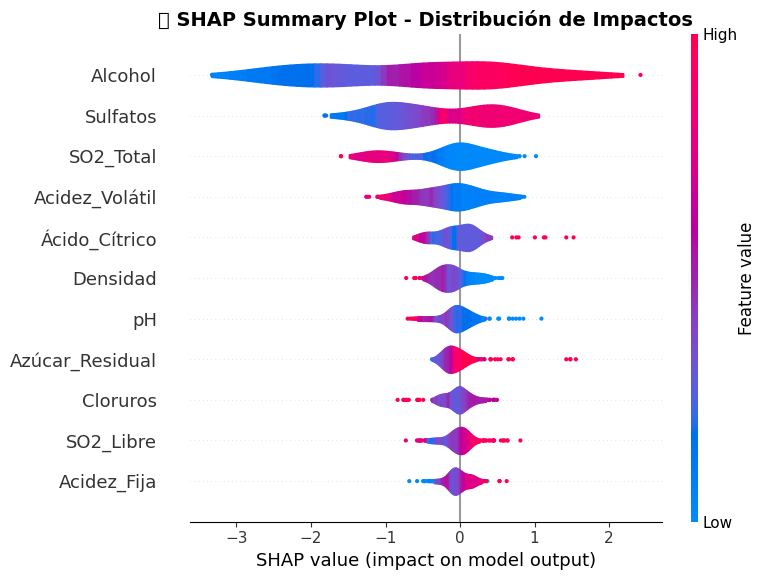

✅ Summary plot (violín) guardado como: shap_summary_violin.png


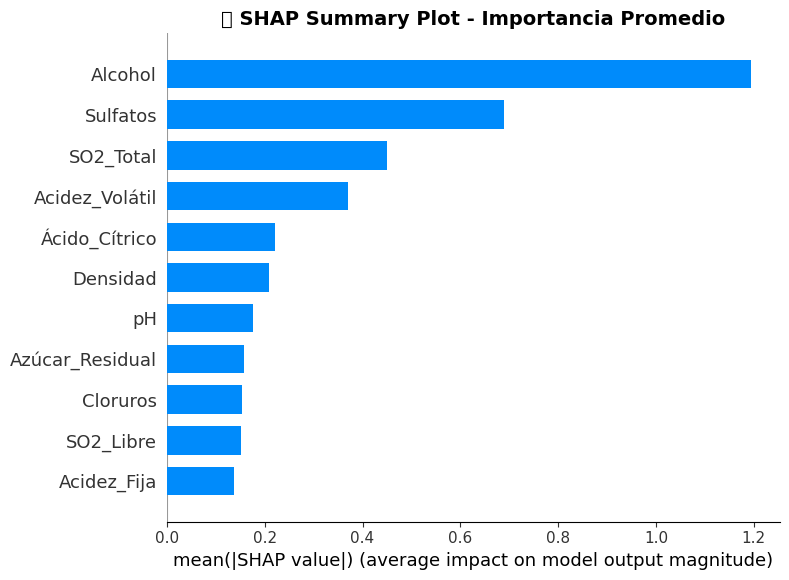

✅ Summary plot (barras) guardado como: shap_summary_bar.png



In [12]:
# ============================================================================
# 📊 1. SUMMARY PLOT - PANORAMA GLOBAL
# ============================================================================

print("📊 1. SUMMARY PLOT - Importancia Global de Features")
print("-" * 50)

# Summary plot tipo violín (muestra distribución de impactos)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="violin", show=False)
plt.title("🎻 SHAP Summary Plot - Distribución de Impactos", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_summary_violin.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Summary plot (violín) guardado como: shap_summary_violin.png")

# Summary plot tipo barra (solo importancia promedio)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("📊 SHAP Summary Plot - Importancia Promedio", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_summary_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Summary plot (barras) guardado como: shap_summary_bar.png")
print()

🌊 2. WATERFALL PLOTS - Explicaciones Paso a Paso
----------------------------------------------------
   🍷 Vino #21 (Alta Calidad - ✅ Correcto)
   Predicción: 0.831 | Real: Alta


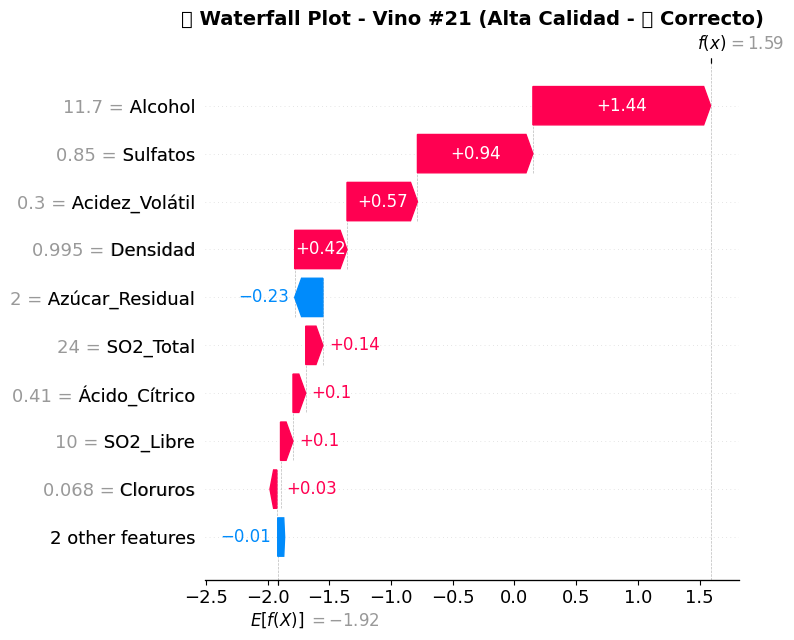

   ✅ Guardado como: waterfall_vino_21.png
   🍷 Vino #0 (Baja Calidad - ✅ Correcto)
   Predicción: 0.165 | Real: Baja/Media


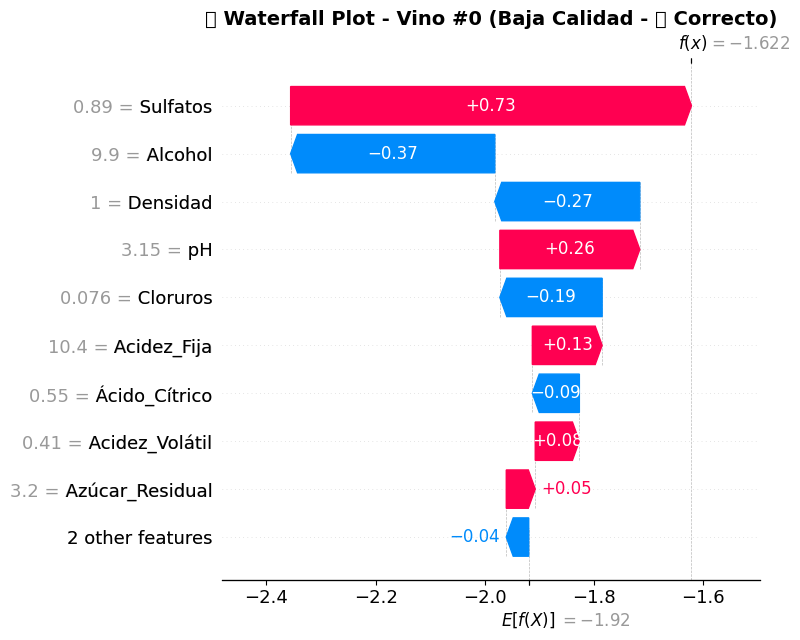

   ✅ Guardado como: waterfall_vino_0.png
   🍷 Vino #56 (❌ Error del Modelo)
   Predicción: 0.012 | Real: Alta


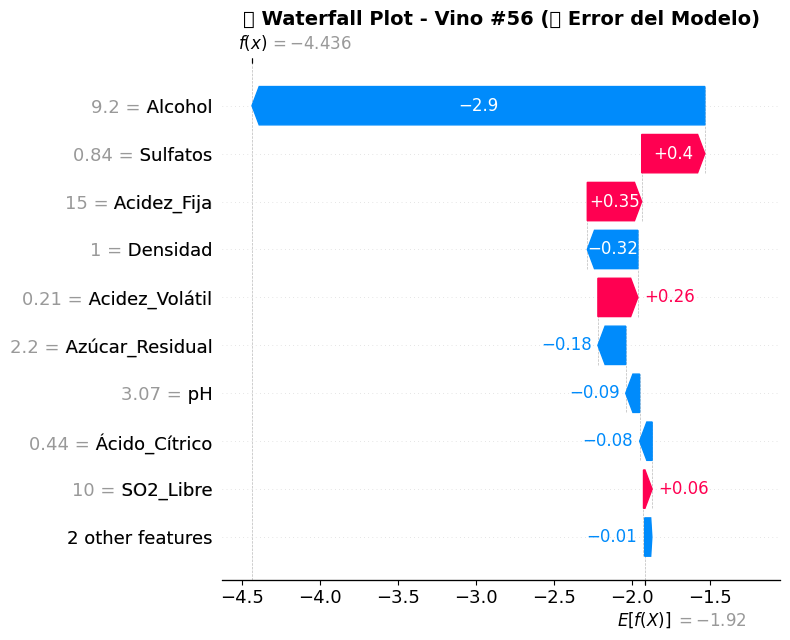

   ✅ Guardado como: waterfall_vino_56.png



In [13]:
# ============================================================================
# 🌊 2. WATERFALL PLOTS - EXPLICACIONES INDIVIDUALES
# ============================================================================

print("🌊 2. WATERFALL PLOTS - Explicaciones Paso a Paso")
print("-" * 52)

# Función para crear waterfall plots mejorados
def crear_waterfall_plot(sample_idx, titulo_extra=""):
    """Crea un waterfall plot para una muestra específica"""
    sample_data = X_test.iloc[sample_idx]
    sample_shap_vals = shap_values[sample_idx]
    sample_pred = y_proba[sample_idx]
    sample_real = y_test.iloc[sample_idx]

    print(f"   🍷 Vino #{sample_idx} {titulo_extra}")
    print(f"   Predicción: {sample_pred:.3f} | Real: {'Alta' if sample_real==1 else 'Baja/Media'}")

    # Waterfall plot usando shap
    plt.figure(figsize=(12, 6))

    # Crear explanation object para waterfall
    explanation = shap.Explanation(
        values=sample_shap_vals,
        base_values=explainer.expected_value,
        data=sample_data.values,
        feature_names=list(sample_data.index)
    )

    shap.waterfall_plot(explanation, show=False)
    plt.title(f"🌊 Waterfall Plot - Vino #{sample_idx} {titulo_extra}",
              fontsize=14, fontweight='bold')
    plt.tight_layout()

    filename = f'waterfall_vino_{sample_idx}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"   ✅ Guardado como: {filename}")
    return sample_pred, sample_real

# Crear waterfall para diferentes casos
# Caso 1: Predicción correcta de alta calidad
high_qual_correct = np.where((y_proba > 0.7) & (y_test == 1))[0]
if len(high_qual_correct) > 0:
    idx = high_qual_correct[0]
    crear_waterfall_plot(idx, "(Alta Calidad - ✅ Correcto)")

# Caso 2: Predicción correcta de baja calidad
low_qual_correct = np.where((y_proba < 0.3) & (y_test == 0))[0]
if len(low_qual_correct) > 0:
    idx = low_qual_correct[0]
    crear_waterfall_plot(idx, "(Baja Calidad - ✅ Correcto)")

# Caso 3: Error del modelo (si existe)
errors = np.where(((y_proba > 0.5) & (y_test == 0)) | ((y_proba < 0.5) & (y_test == 1)))[0]
if len(errors) > 0:
    idx = errors[0]
    crear_waterfall_plot(idx, "(❌ Error del Modelo)")

print()

⚡ 3. FORCE PLOTS - Visualización de Fuerzas
--------------------------------------------
   🎯 Force Plot - Vino #21 (Alta Calidad)


<Figure size 1400x300 with 0 Axes>

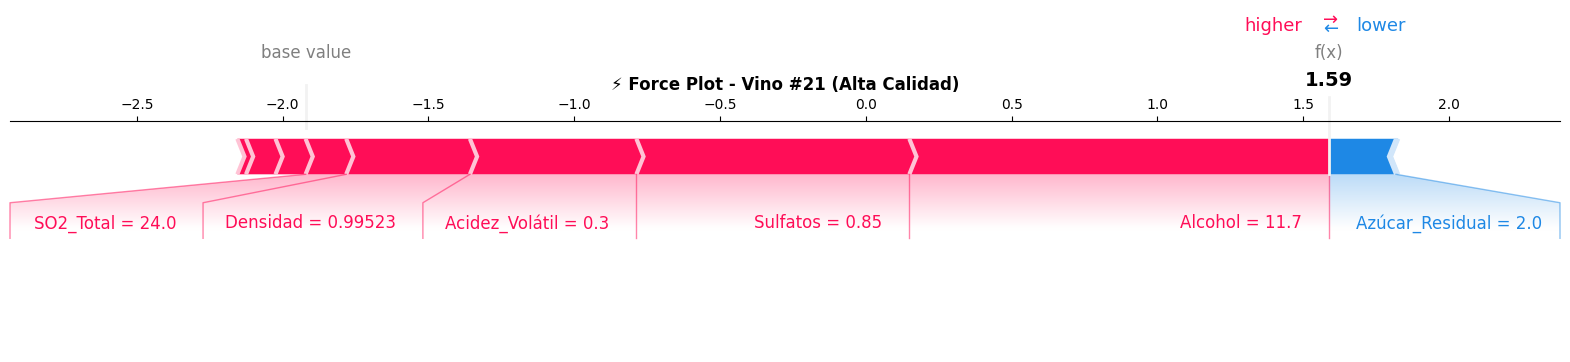

   ✅ Guardado como: force_plot_vino_21.png
   🎯 Force Plot - Vino #0 (Baja Calidad)


<Figure size 1400x300 with 0 Axes>

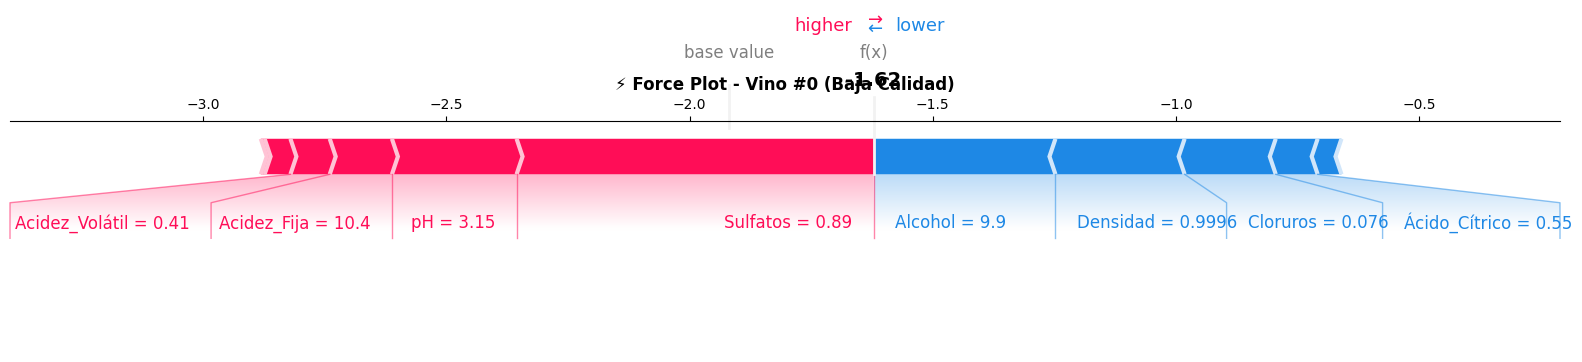

   ✅ Guardado como: force_plot_vino_0.png



In [14]:
# ============================================================================
# ⚡ 3. FORCE PLOTS - FUERZAS INDIVIDUALES
# ============================================================================

print("⚡ 3. FORCE PLOTS - Visualización de Fuerzas")
print("-" * 44)

# Función para crear force plot interpretable
def crear_force_plot(sample_idx, titulo_extra=""):
    """Crea un force plot para una muestra específica"""
    sample_data = X_test.iloc[sample_idx]
    sample_shap_vals = shap_values[sample_idx]
    sample_pred = y_proba[sample_idx]

    print(f"   🎯 Force Plot - Vino #{sample_idx} {titulo_extra}")

    # Force plot clásico
    plt.figure(figsize=(14, 3))
    shap.force_plot(
        explainer.expected_value,
        sample_shap_vals,
        sample_data,
        matplotlib=True,
        show=False
    )
    plt.title(f"⚡ Force Plot - Vino #{sample_idx} {titulo_extra}",
              fontsize=12, fontweight='bold')

    filename = f'force_plot_vino_{sample_idx}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"   ✅ Guardado como: {filename}")

# Crear force plots para los mismos casos
if len(high_qual_correct) > 0:
    crear_force_plot(high_qual_correct[0], "(Alta Calidad)")

if len(low_qual_correct) > 0:
    crear_force_plot(low_qual_correct[0], "(Baja Calidad)")

print()

🎯 4. PARTIAL DEPENDENCE PLOTS - Efecto de cada Feature
--------------------------------------------------------
   📈 Creando PDP para: Alcohol
   📈 Creando PDP para: Sulfatos
   📈 Creando PDP para: SO2_Total
   📈 Creando PDP para: Acidez_Volátil


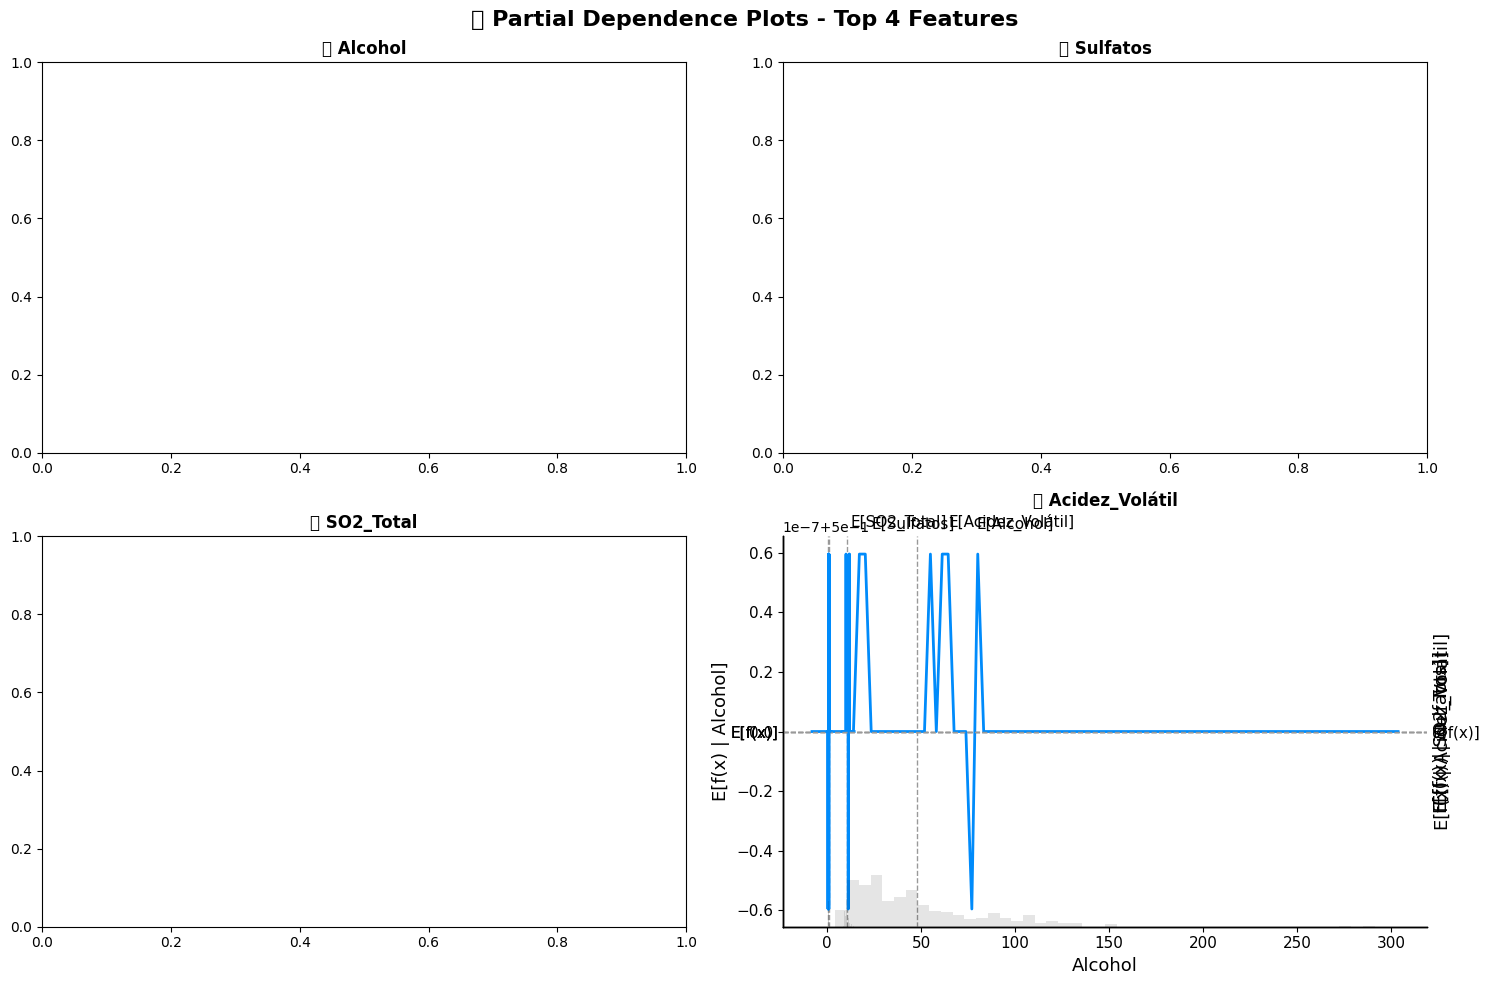

✅ PDPs guardados como: partial_dependence_plots.png



In [15]:
# ============================================================================
# 🎯 4. PARTIAL DEPENDENCE PLOTS - RELACIONES INDIVIDUALES
# ============================================================================

print("🎯 4. PARTIAL DEPENDENCE PLOTS - Efecto de cada Feature")
print("-" * 56)

# Top 4 features más importantes para PDPs
top_features = shap_importance_df.head(4)['Feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    print(f"   📈 Creando PDP para: {feature}")

    # Partial dependence plot
    feature_idx = list(X_test.columns).index(feature)
    shap.partial_dependence_plot(
        feature_idx, model.predict_proba, X_test, ice=False,
        model_expected_value=True, feature_expected_value=True,
        ax=axes[i], show=False
    )
    axes[i].set_title(f"📈 {feature}", fontweight='bold')

plt.suptitle("🎯 Partial Dependence Plots - Top 4 Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('partial_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ PDPs guardados como: partial_dependence_plots.png")
print()

🔥 5. HEATMAP - Patrones en SHAP Values
----------------------------------------


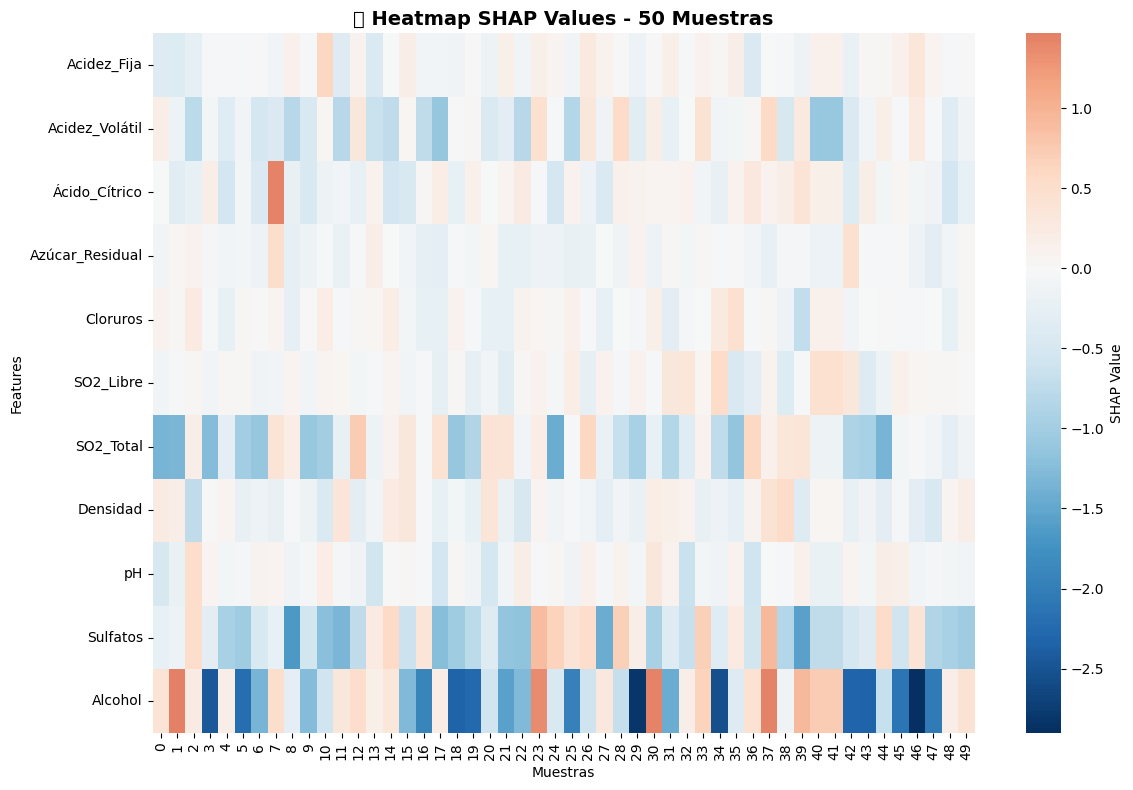

✅ Heatmap guardado como: shap_heatmap.png



In [16]:
# ============================================================================
# 🔥 5. HEATMAP DE SHAP VALUES
# ============================================================================

print("🔥 5. HEATMAP - Patrones en SHAP Values")
print("-" * 40)

# Seleccionar una muestra de observaciones para el heatmap
n_samples_heatmap = min(50, len(X_test))  # Máximo 50 para legibilidad
sample_indices = np.random.choice(len(X_test), n_samples_heatmap, replace=False)

# Crear heatmap
plt.figure(figsize=(12, 8))
shap_heatmap_data = shap_values[sample_indices]

# Heatmap de SHAP values
sns.heatmap(
    shap_heatmap_data.T,  # Transponer para features en filas
    yticklabels=X_test.columns,
    cmap='RdBu_r',  # Rojo-Azul invertido
    center=0,  # Centrar en 0
    cbar_kws={'label': 'SHAP Value'}
)

plt.title(f"🔥 Heatmap SHAP Values - {n_samples_heatmap} Muestras", fontsize=14, fontweight='bold')
plt.xlabel("Muestras")
plt.ylabel("Features")
plt.tight_layout()
plt.savefig('shap_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Heatmap guardado como: shap_heatmap.png")
print()

🎪 6. DECISION PLOT - Camino de Decisión del Modelo
--------------------------------------------------


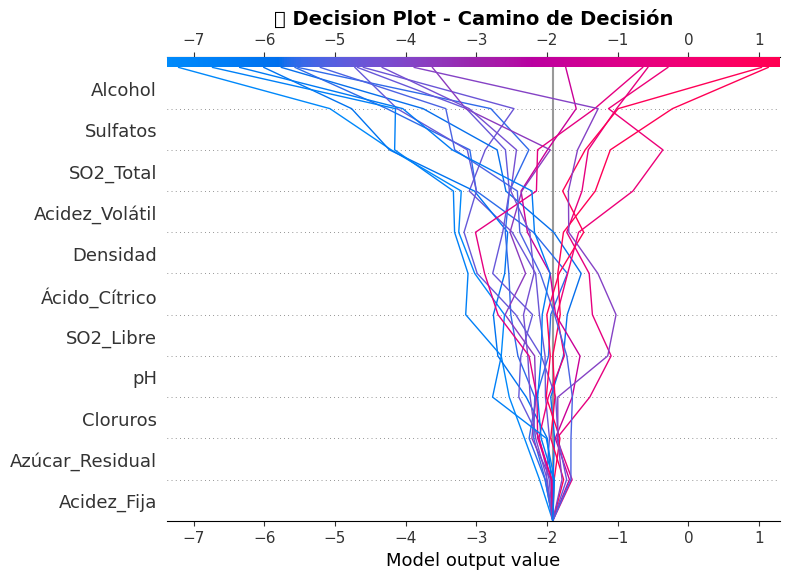

✅ Decision plot guardado como: decision_plot.png



In [17]:
# ============================================================================
# 🎪 6. DECISION PLOT - CAMINO DE DECISIÓN
# ============================================================================

print("🎪 6. DECISION PLOT - Camino de Decisión del Modelo")
print("-" * 50)

# Decision plot para algunas muestras
sample_size = min(20, len(X_test))
sample_idx = np.random.choice(len(X_test), sample_size, replace=False)

plt.figure(figsize=(10, 8))
shap.decision_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_test.iloc[sample_idx],
    show=False
)
plt.title("🎪 Decision Plot - Camino de Decisión", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('decision_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Decision plot guardado como: decision_plot.png")
print()

📊 7. BEESWARM PLOT - Distribución Detallada de Impactos
-------------------------------------------------------


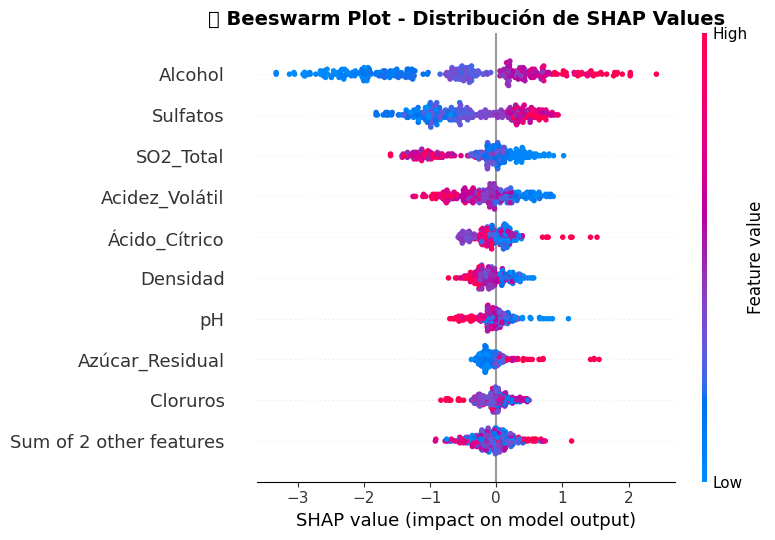

✅ Beeswarm plot guardado como: beeswarm_plot.png



In [18]:
# ============================================================================
# 📊 7. BEESWARM PLOT - DISTRIBUCIÓN DETALLADA
# ============================================================================

print("📊 7. BEESWARM PLOT - Distribución Detallada de Impactos")
print("-" * 55)

plt.figure(figsize=(12, 8))
shap.plots.beeswarm(
    shap.Explanation(
        values=shap_values,
        base_values=explainer.expected_value,
        data=X_test.values,
        feature_names=list(X_test.columns)
    ),
    show=False
)
plt.title("📊 Beeswarm Plot - Distribución de SHAP Values", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('beeswarm_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Beeswarm plot guardado como: beeswarm_plot.png")
print()

In [19]:
# ============================================================================
# 🎨 8. RESUMEN DE VISUALIZACIONES CREADAS
# ============================================================================

print("🎨 RESUMEN DE VISUALIZACIONES CREADAS:")
print("=" * 40)

visualizations = [
    "📊 shap_summary_violin.png - Distribución global de impactos",
    "📊 shap_summary_bar.png - Importancia promedio por feature",
    "🌊 waterfall_vino_*.png - Explicaciones paso a paso individuales",
    "⚡ force_plot_vino_*.png - Fuerzas que empujan cada decisión",
    "🎯 partial_dependence_plots.png - Efecto individual de top features",
    "🔥 shap_heatmap.png - Patrones de SHAP values en múltiples muestras",
    "🎪 decision_plot.png - Camino de decisión del modelo",
    "📊 beeswarm_plot.png - Distribución detallada de impactos"
]

for viz in visualizations:
    print(f"   ✅ {viz}")

print()
print("💡 CÓMO INTERPRETAR CADA VISUALIZACIÓN:")
print("-" * 40)

interpretations = {
    "📊 Summary Plot (Violín)": "Muestra la distribución de impactos de cada feature. Ancho = frecuencia, color = valor del feature",
    "📊 Summary Plot (Barras)": "Ranking simple de importancia promedio. Más largo = más importante",
    "🌊 Waterfall Plot": "Cómo cada feature empuja la predicción desde baseline hasta resultado final",
    "⚡ Force Plot": "Visualiza 'fuerzas' rojas (hacia 0) vs azules (hacia 1) para una predicción",
    "🎯 Partial Dependence": "Cómo cambia la predicción cuando varía una sola feature",
    "🔥 Heatmap": "Patrones de SHAP values: rojo = empuja hacia 0, azul = empuja hacia 1",
    "🎪 Decision Plot": "Camino que sigue el modelo desde baseline hasta predicción final",
    "📊 Beeswarm": "Como summary plot pero muestra cada punto individual (mejor para patrones)"
}

for viz, explanation in interpretations.items():
    print(f"\n{viz}:")
    print(f"   {explanation}")

print()

🎨 RESUMEN DE VISUALIZACIONES CREADAS:
   ✅ 📊 shap_summary_violin.png - Distribución global de impactos
   ✅ 📊 shap_summary_bar.png - Importancia promedio por feature
   ✅ 🌊 waterfall_vino_*.png - Explicaciones paso a paso individuales
   ✅ ⚡ force_plot_vino_*.png - Fuerzas que empujan cada decisión
   ✅ 🎯 partial_dependence_plots.png - Efecto individual de top features
   ✅ 🔥 shap_heatmap.png - Patrones de SHAP values en múltiples muestras
   ✅ 🎪 decision_plot.png - Camino de decisión del modelo
   ✅ 📊 beeswarm_plot.png - Distribución detallada de impactos

💡 CÓMO INTERPRETAR CADA VISUALIZACIÓN:
----------------------------------------

📊 Summary Plot (Violín):
   Muestra la distribución de impactos de cada feature. Ancho = frecuencia, color = valor del feature

📊 Summary Plot (Barras):
   Ranking simple de importancia promedio. Más largo = más importante

🌊 Waterfall Plot:
   Cómo cada feature empuja la predicción desde baseline hasta resultado final

⚡ Force Plot:
   Visualiza 'fuerz

In [20]:
# ============================================================================
# 🎯 9. FUNCIÓN PARA EXPLICAR VISUALMENTE CUALQUIER VINO
# ============================================================================

def explicar_vino_visual(wine_index):
    """
    Crea todas las visualizaciones para un vino específico
    """
    if wine_index >= len(X_test):
        print(f"❌ Índice fuera de rango. Máximo: {len(X_test)-1}")
        return

    print(f"🍷 ANÁLISIS VISUAL COMPLETO - VINO #{wine_index}")
    print("=" * 50)

    # Datos básicos
    sample_data = X_test.iloc[wine_index]
    sample_shap_vals = shap_values[wine_index]
    sample_pred = y_proba[wine_index]
    sample_real = y_test.iloc[wine_index]

    print(f"Predicción: {sample_pred:.3f} ({sample_pred*100:.1f}%)")
    print(f"Real: {'Alta calidad' if sample_real == 1 else 'Baja/media calidad'}")
    print(f"Estado: {'✅ Correcto' if (sample_pred > 0.5) == sample_real else '❌ Incorrecto'}")
    print()

    # 1. Waterfall plot
    plt.figure(figsize=(12, 6))
    explanation = shap.Explanation(
        values=sample_shap_vals,
        base_values=explainer.expected_value,
        data=sample_data.values,
        feature_names=list(sample_data.index)
    )
    shap.waterfall_plot(explanation, show=False)
    plt.title(f"🌊 Waterfall - Vino #{wine_index}", fontweight='bold')
    plt.tight_layout()
    plt.show()

    # 2. Force plot
    plt.figure(figsize=(14, 3))
    shap.force_plot(
        explainer.expected_value,
        sample_shap_vals,
        sample_data,
        matplotlib=True,
        show=False
    )
    plt.title(f"⚡ Force Plot - Vino #{wine_index}", fontweight='bold')
    plt.tight_layout()
    plt.show()

    # 3. Tabla resumen
    contributions = pd.DataFrame({
        'Feature': sample_data.index,
        'Valor': sample_data.values,
        'SHAP': sample_shap_vals,
        'Impacto': ['📈 Positivo' if x > 0 else '📉 Negativo' if x < 0 else '➖ Neutral' for x in sample_shap_vals]
    }).round(3)

    contributions['SHAP_Abs'] = abs(contributions['SHAP'])
    contributions = contributions.sort_values('SHAP_Abs', ascending=False).drop('SHAP_Abs', axis=1)

    print("📋 TABLA RESUMEN:")
    print(contributions.to_string(index=False))

    return contributions

print("🎁 FUNCIÓN PARA ANÁLISIS VISUAL COMPLETO:")
print("   explicar_vino_visual(indice)")
print("   Ejemplo: explicar_vino_visual(0)")
print()

print("🎉 ¡VISUALIZACIONES SHAP COMPLETAS!")
print("=" * 35)
print("✅ 8 tipos diferentes de gráficos creados")
print("✅ Múltiples perspectivas del mismo modelo")
print("✅ Archivos PNG guardados para presentaciones")
print("✅ Función interactiva para explorar cualquier caso")
print()
print("🚀 ¡Ahora tienes explicabilidad VISUAL completa!")
print("   Cada gráfico cuenta una parte diferente de la historia")
print("   Combínalos para obtener insights profundos")

🎁 FUNCIÓN PARA ANÁLISIS VISUAL COMPLETO:
   explicar_vino_visual(indice)
   Ejemplo: explicar_vino_visual(0)

🎉 ¡VISUALIZACIONES SHAP COMPLETAS!
✅ 8 tipos diferentes de gráficos creados
✅ Múltiples perspectivas del mismo modelo
✅ Archivos PNG guardados para presentaciones
✅ Función interactiva para explorar cualquier caso

🚀 ¡Ahora tienes explicabilidad VISUAL completa!
   Cada gráfico cuenta una parte diferente de la historia
   Combínalos para obtener insights profundos


### Conclusión

Resumen

In [22]:
# ============================================================================
# 📈 PASO 11: RESUMEN EJECUTIVO
# ============================================================================

print("📈 RESUMEN EJECUTIVO:")
print("=" * 25)

print(f"🍷 Dataset: {X.shape[0]} vinos, {X.shape[1]} características")
print(f"🎯 Problema: Clasificar vinos de alta vs baja/media calidad")
print(f"🚀 Modelo: XGBoost con {accuracy*100:.1f}% de precisión")
print()

print("🏆 TOP 3 FACTORES MÁS IMPORTANTES (según SHAP):")
for i, row in shap_importance_df.head(3).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Mean_SHAP_Importance']:.3f}")
print()

print("💡 INSIGHTS CLAVE:")
print(f"   • El modelo funciona {'bien' if accuracy > 0.8 else 'decentemente' if accuracy > 0.7 else 'regular'}")
print("   • SHAP nos permite explicar cada decisión individual")
print("   • Podemos identificar por qué el modelo se equivoca")
print("   • Transparencia total: sabemos qué influye en cada predicción")
print()

print("🎯 PRÓXIMOS PASOS SUGERIDOS:")
print("   1. Crear gráficos SHAP (waterfall, summary, force plots)")
print("   2. Analizar patrones en casos incorrectos")
print("   3. Optimizar modelo basándose en insights de SHAP")
print("   4. Implementar explicaciones automáticas para usuarios finales")

# ============================================================================
# 🎨 CÓDIGO BONUS: FUNCIÓN PARA EXPLICAR CUALQUIER VINO
# ============================================================================

def explicar_vino(wine_index, detailed=True):
    """
    Función para explicar la predicción de cualquier vino del dataset de test

    Args:
        wine_index (int): Índice del vino en el conjunto de test
        detailed (bool): Si mostrar explicación detallada
    """
    if wine_index >= len(X_test):
        print(f"❌ Índice {wine_index} fuera de rango. Máximo: {len(X_test)-1}")
        return

    # Obtener datos
    sample = X_test.iloc[wine_index]
    shap_vals = shap_values[wine_index]
    prediction = y_proba[wine_index]
    real_value = y_test.iloc[wine_index]

    print(f"🍷 EXPLICACIÓN VINO #{wine_index}")
    print("-" * 30)
    print(f"Predicción: {prediction:.3f} ({'Alta calidad' if prediction > 0.5 else 'Baja/media calidad'})")
    print(f"Real: {'Alta calidad' if real_value == 1 else 'Baja/media calidad'}")
    print(f"Correcto: {'✅' if (prediction > 0.5) == real_value else '❌'}")

    if detailed:
        print(f"\nBaseline: {explainer.expected_value:.3f}")
        print("Contribuciones:")
        for feature, shap_val, feature_val in zip(feature_names, shap_vals, sample):
            direction = "↗️" if shap_val > 0 else "↘️"
            print(f"  {direction} {feature}: {feature_val:.3f} → {shap_val:+.3f}")

    return {
        'prediction': prediction,
        'real': real_value,
        'shap_values': shap_vals,
        'features': sample
    }


print("¡Ahora puedes responder al 'por qué' detrás de cada predicción!")

📈 RESUMEN EJECUTIVO:
🍷 Dataset: 1599 vinos, 11 características
🎯 Problema: Clasificar vinos de alta vs baja/media calidad
🚀 Modelo: XGBoost con 93.8% de precisión

🏆 TOP 3 FACTORES MÁS IMPORTANTES (según SHAP):
   11. Alcohol: 1.194
   10. Sulfatos: 0.688
   7. SO2_Total: 0.449

💡 INSIGHTS CLAVE:
   • El modelo funciona bien
   • SHAP nos permite explicar cada decisión individual
   • Podemos identificar por qué el modelo se equivoca
   • Transparencia total: sabemos qué influye en cada predicción

🎯 PRÓXIMOS PASOS SUGERIDOS:
   1. Crear gráficos SHAP (waterfall, summary, force plots)
   2. Analizar patrones en casos incorrectos
   3. Optimizar modelo basándose en insights de SHAP
   4. Implementar explicaciones automáticas para usuarios finales
¡Ahora puedes responder al 'por qué' detrás de cada predicción!
